<a href="https://colab.research.google.com/github/ChintPatel/CMPE255-advanced-dimensionality-reduction/blob/main/Data_Bricks_Dim_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn umap-learn matplotlib pandas

In [2]:
from pyspark.sql import SparkSession
import pandas as pd

# Create a SparkSession
spark = SparkSession.builder.appName("NetflixData").getOrCreate()

# Load dataset into a Spark DataFrame
file_path = "/content/netflix_titles.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert to Pandas for preprocessing
pandas_df = df.toPandas()
print(pandas_df.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water             None   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans             None   
4      s5  TV Show           Kota Factory             None   

                                                cast        country  \
0                                               None  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...           None   
3                                               None           None   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added release_year rating   duration  \
0  September 25, 2021         2020  PG-13     90 min   
1  September 24, 2021         2021  TV-MA  2 Seasons   
2  September 24, 2021         20

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Handle duration column and encode categorical features
pandas_df['duration'] = pandas_df['duration'].str.extract('(\d+)').astype(float)

categorical_features = ['type', 'rating', 'release_year']
numerical_features = ['duration']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


# Transform and standardize the data
X = preprocessor.fit_transform(pandas_df)

# Option 1: Convert to dense matrix (if the dataset isn't too large)
X_dense = X.toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

# Option 2: Use StandardScaler with sparse support
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

print(f"Processed Data Shape: {X_scaled.shape}")



Processed Data Shape: (8809, 137)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[8.89554779e-15 4.57308932e-07 1.56431043e-06 1.93220095e-05]
not reaching the requested tolerance 2.5033950805664062e-06.
Use iteration 1798 instead with accuracy 
3.707719149221122e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.82110652e-15 4.70702332e-07 1.60322536e-06 1.27569497e-05]
not reaching the requested tolerance 2.5033950805664062e-06.
  _, diffusion_map = lobpc

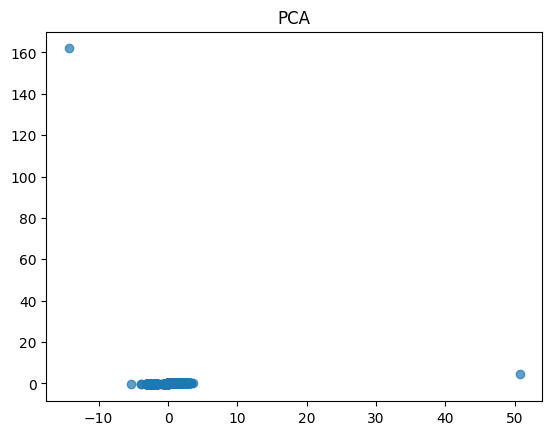

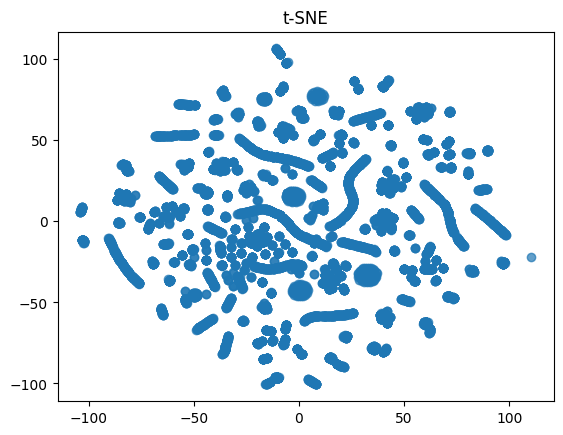

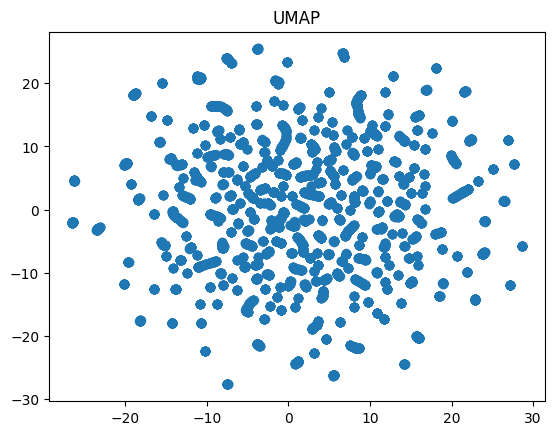

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='random').fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Visualize Results
def plot_embedding(X, title):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], alpha=0.7)
    plt.title(title)
    plt.show()

plot_embedding(X_pca, "PCA")
plot_embedding(X_tsne, "t-SNE")
plot_embedding(X_umap, "UMAP")
